In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy


In [18]:
train = pd.read_csv('train.csv', index_col='Id')

In [19]:
test = pd.read_csv('test.csv', index_col='Id')
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


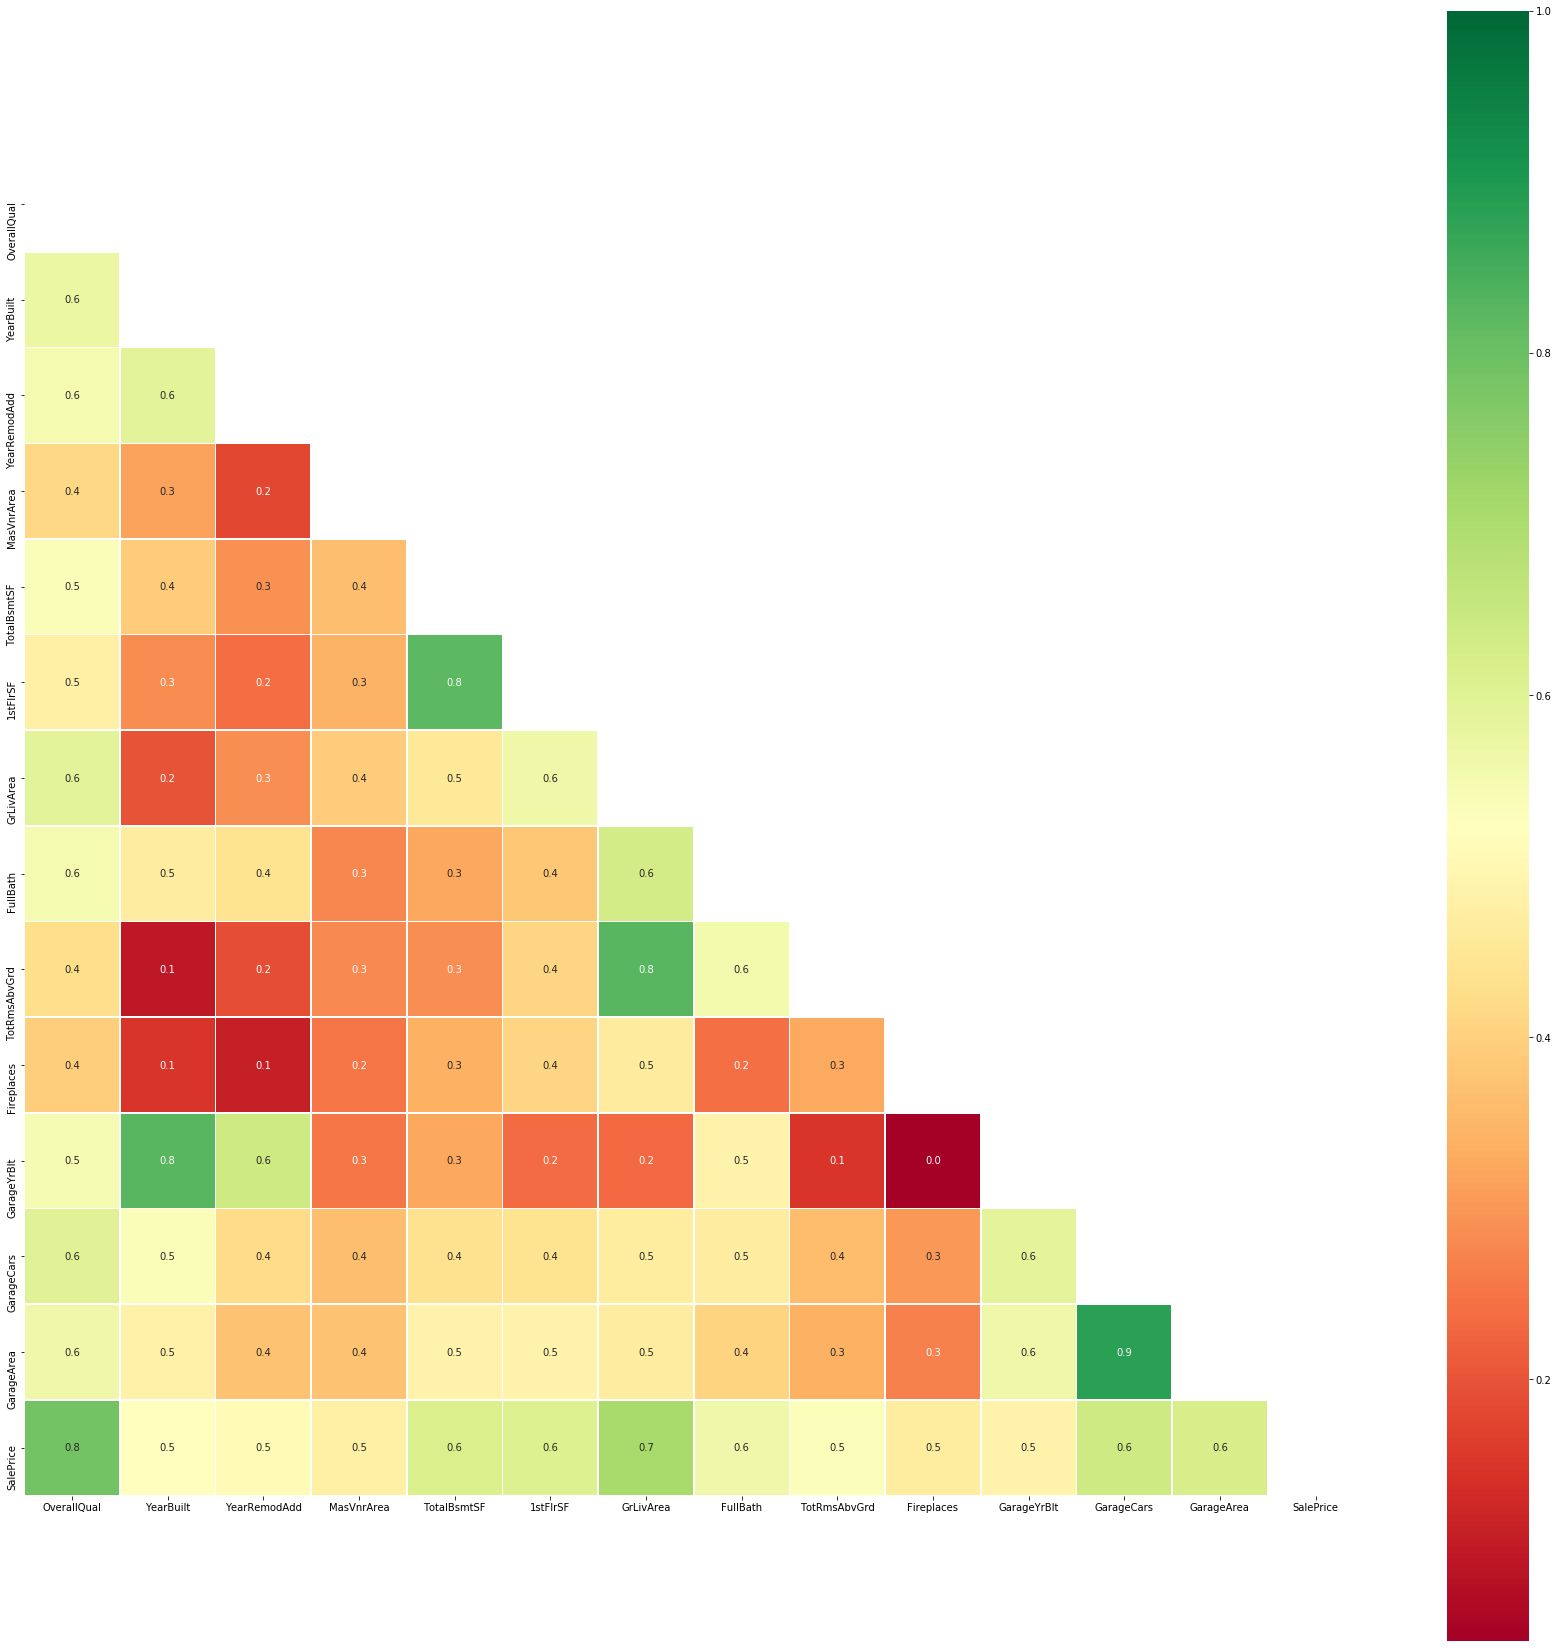

In [20]:
fig, ax = plt.subplots(figsize=(30,30))

corr = train.corr()

b_corr = corr.index[np.abs(corr['SalePrice'] >= 0.4)]

corr = train[b_corr].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=.5, mask=mask,annot=True, fmt=".1f",ax=ax)

In [21]:
def dropna(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])
    return df_copy

In [22]:
def fillna(df):
    df_copy = df.copy()
    #df_copy = dropna(df_copy)
    for i in df_copy.columns:
        miss_count = df_copy[i].isna().sum() #Посчитайте общее количество пропущенных данных по каждому признаку
        miss = miss_count * (100.0 / df_copy[i].values.size) #посчитайте долю пропущенных данных выборки
        if miss >= 10.0:
            print(miss)
            print(i)
            df_copy.drop(i, axis=1, inplace=True) #удалите из выборки признаки, доля пропущенных которых больще 10%
            continue
        if df_copy[i].dtype == np.object:
            df_copy.fillna({i:'unknown'}, inplace=True) #пропущенные категориальные заполните словом 'unknown' (у них dtype object)
            continue
        df_copy.fillna({i:df_copy[i].mean()}, inplace=True) #пропущенные числовые заполните средним (у них dtype float)
    return df_copy

In [23]:
def prepare_data(df):
    df_copy = df.copy()
    df_copy = fillna(df_copy)
    df_copy = pd.get_dummies(df_copy)
    df_copy = StandardScaler().fit_transform(df_copy)
    return df_copy

In [24]:
def test_model(model):
    print(model)
    scores = np.sqrt(abs(cross_val_score(model, X, y, cv=k_ford, scoring='neg_mean_squared_error')))
    print(scores)
    print(scores.mean())
    print("Доля ошибок: {:.4%}".format((scores.mean()*X.shape[0]) / np.sum(y)))

In [25]:
def make_sub(model):
    model = model.fit(X, y)
    pre_test = prepare_data(test)
    sub = pd.DataFrame()
    sub['Id'] = test.index + 1
    sub['SalePrice'] = model.predict(pre_test)
    sub.to_csv('submission.csv',index=False)

In [26]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data = fillna(all_data)

93.21685508735868
Alley
80.4385063377869
Fence
48.646796848235695
FireplaceQu
16.649537512846866
LotFrontage
96.40287769784172
MiscFeature
99.65741692360398
PoolQC


/home/byzilio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [27]:
all_data = pd.get_dummies(all_data)


In [28]:

train = all_data[:ntrain]
test = all_data[ntrain:]

In [29]:
X = train

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

/home/byzilio/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [31]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [32]:
k_ford = KFold(5, shuffle=True, random_state=42)

In [33]:
models = [#Lasso(alpha=0.0005, random_state=1, max_iter=1000),
          Ridge(alpha=0.00005, random_state=1),
          GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=42),
          GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=42),
          xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
         ]
for i in models:
    test_model(i)

Ridge(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)
[29560.37987031 27007.63630161 55124.16379105 35264.98544671
 23051.01472342]
34001.63602661918
Доля ошибок: 18.7936%
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
[28307.44042051 24909.26415039 39119.69222082 25644.13476861
 18175.74109636]
27231.254531336883
Доля ошибок: 15.0514%
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
            

### Не мой код. Тест почему получаются адовые числа

In [ ]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics



In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))


In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)


In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
score = rmsle_cv(lasso)
print(score)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = MinMaxScaler().fit_transform(score)

print(score)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
